# SGD on Diagonal Linear Networks

Replicating / investigating some results from the paper https://arxiv.org/pdf/2302.08982

Batch size: 1, LR: 0.0001, Train loss: 0.0012618564822963496, Test loss: 1.142012, Iterations: 100000
Batch size: 1, LR: 0.0001221053502998154, Train loss: 0.0009142304571460836, Test loss: 1.150162, Iterations: 100000
Batch size: 1, LR: 0.00014909716571840644, Train loss: 0.000627583141830696, Test loss: 1.158760, Iterations: 100000
Batch size: 1, LR: 0.00018205561648755648, Train loss: 0.0003964920698077395, Test loss: 1.165256, Iterations: 100000
Batch size: 1, LR: 0.00022229964825261955, Train loss: 0.00024650404161010196, Test loss: 1.171155, Iterations: 100000
Batch size: 1, LR: 0.0002714397642141186, Train loss: 0.00014543218563290054, Test loss: 1.176669, Iterations: 100000
Batch size: 1, LR: 0.0003314424749466425, Train loss: 8.709888101174137e-05, Test loss: 1.177574, Iterations: 100000
Batch size: 1, LR: 0.00040470899507597614, Train loss: 5.087976057456266e-05, Test loss: 1.179879, Iterations: 100000
Batch size: 1, LR: 0.0004941713361323833, Train loss: 2.7203896311964187e-

/var/folders/g5/npqksqc90_34xrpm8z4vpprr0000gn/T/ipykernel_5979/665714371.py:15: RuntimeWarning: overflow encountered in multiply
  return X @ (u * v)
/var/folders/g5/npqksqc90_34xrpm8z4vpprr0000gn/T/ipykernel_5979/665714371.py:15: RuntimeWarning: invalid value encountered in matmul
  return X @ (u * v)


Batch size: 1, LR: 0.29470517025518095, Train loss: nan, Test loss: nan, Iterations: 100000
Batch size: 20, LR: 0.0001, Train loss: 0.001292182294944547, Test loss: 1.141402, Iterations: 100000
Batch size: 20, LR: 0.0001221053502998154, Train loss: 0.0009092348008000279, Test loss: 1.150749, Iterations: 100000
Batch size: 20, LR: 0.00014909716571840644, Train loss: 0.0006148545516115569, Test loss: 1.158929, Iterations: 100000
Batch size: 20, LR: 0.00018205561648755648, Train loss: 0.0003973328683946675, Test loss: 1.165925, Iterations: 100000
Batch size: 20, LR: 0.00022229964825261955, Train loss: 0.00024580799704302503, Test loss: 1.171565, Iterations: 100000
Batch size: 20, LR: 0.0002714397642141186, Train loss: 0.00014694412411702656, Test loss: 1.175669, Iterations: 100000
Batch size: 20, LR: 0.0003314424749466425, Train loss: 8.599699304249209e-05, Test loss: 1.178170, Iterations: 100000
Batch size: 20, LR: 0.00040470899507597614, Train loss: 4.95331167007034e-05, Test loss: 1.17

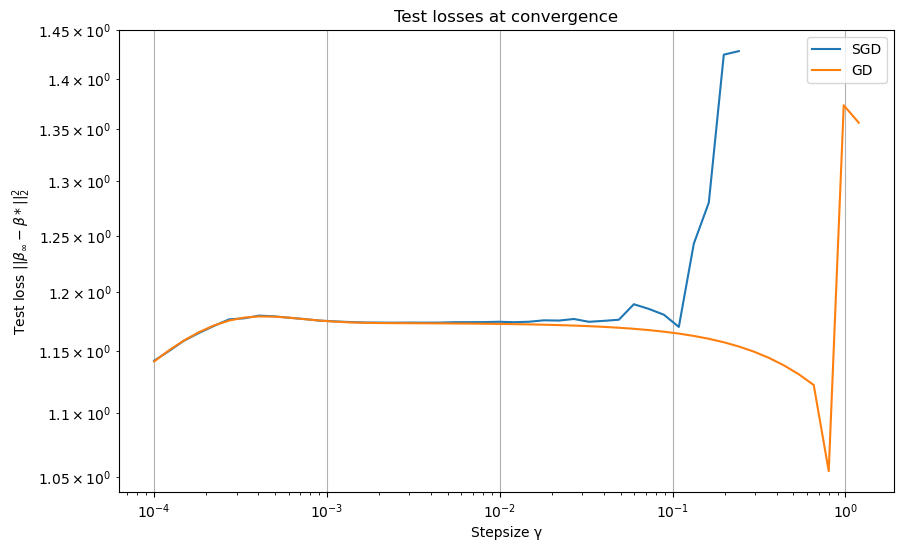

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def generate_sparse_regression_data(n, d, s, seed=None):
    if seed is not None:
        np.random.seed(seed)
    X = np.random.randn(n, d)
    beta_star = np.zeros(d)
    non_zero_indices = np.random.choice(d, s, replace=False)
    beta_star[non_zero_indices] = np.random.randn(s)
    y = X @ beta_star
    return X, y, beta_star

def dln_predict(u, v, X):
    return X @ (u * v)

def dln_loss(u, v, X, y):
    return 0.5 * np.mean((y - dln_predict(u, v, X))**2)

def dln_sgd_step(u, v, X, y, lr):
    batch_size = X.shape[0]
    error = y - dln_predict(u, v, X)
    grad_u = -np.mean(error[:, np.newaxis] * v * X, axis=0)
    grad_v = -np.mean(error[:, np.newaxis] * u * X, axis=0)
    u -= lr * grad_u
    v -= lr * grad_v
    return u, v

def train_dln(X, y, X_test, y_test, alpha, lr, batch_size, max_iter=100000, tol=1e-6):
    d = X.shape[1]
    u = np.sqrt(2*alpha) * np.ones(d)
    v = np.zeros(d)
    
    for i in range(max_iter):
        if batch_size < X.shape[0]:
            batch_indices = np.random.choice(X.shape[0], batch_size, replace=False)
            X_batch, y_batch = X[batch_indices], y[batch_indices]
        else:
            X_batch, y_batch = X, y
        
        u, v = dln_sgd_step(u, v, X_batch, y_batch, lr)
        
        if i % 1000 == 0:
            test_loss = np.mean((y_test - dln_predict(u, v, X_test))**2)
            if test_loss < tol:
                break
    
    return u, v, i+1

# Set up the experiment
n, d, s = 20, 30, 3
alpha = 0.1
X, y, beta_star = generate_sparse_regression_data(n, d, s, seed=42)
X_test, y_test, _ = generate_sparse_regression_data(n, d, s, seed=43)

# Train for different stepsizes and batch sizes
stepsizes = np.logspace(-4, 0.25, 50)
batch_sizes = [1, n]  # SGD and GD
test_losses = {1: [], n: []}

for batch_size in batch_sizes:
    for lr in stepsizes:
        u, v, iters = train_dln(X, y, X_test, y_test, alpha, lr, batch_size)
        test_loss = dln_loss(u, v, X_test, y_test)
        train_loss = dln_loss(u, v, X, y)
        test_losses[batch_size].append(test_loss)
        print(f"Batch size: {batch_size}, LR: {lr}, Train loss: {train_loss}, Test loss: {test_loss:.6f}, Iterations: {iters}")
        
        if np.isnan(test_loss) or test_loss > 1e5:
            break

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(stepsizes[:len(test_losses[1])], test_losses[1], label="SGD")
plt.plot(stepsizes[:len(test_losses[n])], test_losses[n], label="GD")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Stepsize γ')
plt.ylabel('Test loss $||β_∞ - β*||_2^2$')
plt.title('Test losses at convergence')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def hypentropy(alpha, beta):
    """
    The hyperbolic entropy function defined in equation (4).

    alpha, beta are ndarrays of shape (d,)
    """
    return 0.5 * np.sum(beta * np.arcsinh(beta / alpha**2) - np.sqrt(beta**2 + alpha**4) + alpha**2)

def grad_hypentropy(alpha, beta):
    return 0.5 * np.arcsinh(beta / alpha**2)

def bregman_hypentropy(alpha, x, y):
    return 0.5 * np.sum( np.sqrt(y**2 + alpha**4) - np.sqrt(x**2 + alpha**4) + x * (np.arcsinh(x / alpha**2) - np.arcsinh(y / alpha**2)) )

def grad_bregman_hypentropy(alpha, x, y):
    """gradient of D_ψ_α with respect to the first argument"""
    return grad_hypentropy(alpha, x) - grad_hypentropy(alpha, y)

In [ ]:
def effective_initialization(alpha, updates):
    """
    The "effective initialization" term α_∞ from Theorem 1.

    alpha is the actual initialization
    updates should be an iterable containing the gradient updates,
     i.e. γ_k * ∇L(β_k) for each step k.
    """
    def q_aux_fn(x):
        return -0.5 * np.log((1 - x**2)**2)
    exp_term = np.exp( -np.sum([q_aux_fn(update) for update in updates]) )
    return np.sqrt(alpha**2 * exp_term)


def perturbation_term(alpha, updates):
    def q_plus(x):
        return -2*x - np.log((1 - x)**2)
    def q_minus(x):
        return 2*x - np.log((1 + x)**2)
    
    exp_plus = np.exp( -np.sum([q_plus(update) for update in updates]) )
    exp_minus = np.exp( -np.sum([q_minus(update) for update in updates]) )
    alpha_plus_squared = alpha**2 * exp_plus
    alpha_minus_squared = alpha**2 * exp_minus

    return 0.5 * (alpha_plus_squared - alpha_minus_squared)
    

### Graphs, checks for hypentropy function

In [ ]:
def bregman_divergence_check(d, n):
    """compare bregman_hypentropy to the explicit defn of bregman divergence"""
    for _ in range(n):
        alpha, x, y = np.random.uniform(0,10, size=(d)), np.random.uniform(0,10, size=(d)), np.random.uniform(0,10, size=(d))
        breg_defn = hypentropy(alpha, x) - hypentropy(alpha, y) - np.sum(grad_hypentropy(alpha, y) * (x-y))
        assert np.allclose(breg_defn, bregman_hypentropy(alpha, x, y))
    print(f"bregman_hypentropy function passed all {n} tests.")

bregman_divergence_check(100, 1000)

In [ ]:
def asymptotic_small_scale(scale, beta):
    return np.log(1 / scale) * np.sum(np.abs(beta))

def asymptotic_large_scale(scale, beta):
    return np.sum(beta**2) / (2 * scale**2)

# Parameters
d = 10
scales = np.logspace(-3, 3, 500)  # scale values from 0.001 to 1000
beta = np.arange(d)

# Calculate hypentropy and asymptotic approximations for 1D
hyp = [hypentropy(scale * np.ones_like(beta), beta) for scale in scales]
asymp_small= [asymptotic_small_scale(scale, beta) for scale in scales]
asymp_large = [asymptotic_large_scale(scale, beta) for scale in scales]

# Plotting
plt.plot(scales, hyp, label='hypentropy: $\psi_{\mathbf{\\alpha}}(\\beta)$')
plt.plot(scales, asymp_small, label='$\ln(1/\\alpha) \|\\beta\|_1$', linestyle='--')
plt.plot(scales, asymp_large, label='$\|\\beta\|_2^2 / (2 \\alpha^2)$', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$α$ (scale)')
plt.ylabel('$\psi_{\mathbf{\\alpha}}(\\beta)$ (hypentropy)')
plt.title('Asymptotics of Hypentropy with $\mathbf{α} = α \mathbf{1}$ (fixed $\\beta$)')
plt.legend()
plt.show()


In [ ]:
def weighted_small_scale(alpha, beta):
    return np.sum( np.log(1 / alpha) * np.abs(beta) )

def weighted_large_scale(alpha, beta):
    """NOT CORRECT RIGHT NOW. Also I don't think it's really important."""
    return np.sum(beta**2) / (2 * np.sum(alpha**2) )


# Calculate hypentropy and asymptotic approximations for 1D
# alphas = [scale * np.arange(1, 1+np.size(beta), step=100) for scale in scales]
alphas = [scale * np.logspace(-2, 2, np.size(beta)) for scale in scales]
hyp_weighted = [hypentropy(alpha, beta) for alpha in alphas]
asymp_small_weighted= [weighted_small_scale(alpha, beta) for alpha in alphas]
#asymp_large_weighted = [weighted_large_scale(alpha, beta) for alpha in alphas]  # not correct right now
weighted_scales = [np.sum(alpha) for alpha in alphas]  # actual measurement of "scale"

# Plotting
plt.plot(weighted_scales, hyp_weighted, label='hypentropy: $\psi_{\mathbf{\\alpha}}(\\beta)$')
plt.plot(weighted_scales, asymp_small_weighted, label='$\sum \ln(1/α_i) |β_i|$', linestyle='--')
#plt.plot(weighted_scales, asymp_large_weighted, label='$\|\\beta\|_2^2 / (2 \\alpha^2)$', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\|\mathbf{α}\|_1$ (scale)')
plt.ylabel('$\psi_{\mathbf{\\alpha}}(\\beta)$ (hypentropy)')
plt.title('Asymptotics of Hypentropy with non-uniform $\mathbf{α}$')
plt.legend()
plt.show()

## SGD results

In [ ]:
def DLN(u, v, x):
    return np.inner(u*v, x)

def batch_loss(u, v, batch):
    return 0.5 * np.mean([(y - DLN(u,v,x))**2 for (x,y) in batch])

def sgd_update(u, v, lr, batch):
    """
    Updates u,v via SGD.
    Returns lr * ∇L(β_k), to be used for calculating α_∞ and β*_∞.

    (Note the difference between F and L in equation (2):
      F: R^(2d) -> R, while L: R^d -> R.)
    """
    X, Y = zip(*batch)
    errors = Y - np.sum(u * v * X, axis=1) 
    dF_du = -np.mean(errors[:, np.newaxis] * v * X, axis=0)
    dF_dv = -np.mean(errors[:, np.newaxis] * u * X, axis=0)
    
    u -= lr * dF_du
    v -= lr * dF_dv
    
    dL_dbeta = np.mean(errors[:, np.newaxis] * X, axis=0)
    #dL_dbeta = np.mean([(y - DLN(u,v,x)) * x for (x,y) in batch])  # TODO: FIX THIS, mean over wrong dimension
    return lr * dL_dbeta

def generate_sparse_regression_data(n, d, s, seed=None):
    """
    n (int): Number of samples
    d (int): Dimension of the input vectors
    s (int): Sparsity of beta_star
    seed (int, optional): Random seed for reproducibility

    Returns:
    X (ndarray): Generated input data of shape (n, d)
    y (ndarray): Generated output data of shape (n,)
    beta_star (ndarray): s-sparse vector of shape (d,)
    """
    if seed is not None:
        np.random.seed(seed)

    # Generate input data from standard normal distribution
    X = np.random.randn(n, d)

    # Generate a s-sparse vector beta_star
    beta_star = np.zeros(d)
    non_zero_indices = np.random.choice(d, s, replace=False)
    beta_star[non_zero_indices] = np.random.randn(s)

    # Compute the output data
    y = X @ beta_star

    return X, y, beta_star

In [ ]:
seed = 123

max_epochs = 20000
n = 20   # Number of samples
d = 30   # Dimension of the input vectors
s = 3   # Number of non-zero entries in the sparse vector
a = 0.1  # Initialization scale

eps = 1e-8  # convergence threshold
bs = 1   # batch size

# train, test data
X_train, y_train, beta_star = generate_sparse_regression_data(n, d, s, seed)
X_test = np.random.randn(n, d)
y_test = X_test @ beta_star

# generate batches
train_batches = [list(zip(X_train[k:k+bs], y_train[k:k+bs])) for k in range(0, n, bs)]
assert len(train_batches) == n//bs

# initialization
alpha0 = a * np.ones(d)
u = alpha0
v = 0.1 * np.random.randn(d)

# quantities to track
updates = []
us, vs = [], []
train_losses = []
test_losses = []
n_epochs = 0

lr = 0.001
# run SGD to convergence
for i in range(max_epochs):
    # single epoch of SGD batch size 1
    for batch in train_batches:
        us.append(u)
        vs.append(v)
        updates.append(sgd_update(u, v, lr, batch))

    train_losses.append(batch_loss(u, v, zip(X_train, y_train)))
    test_losses.append(batch_loss(u, v, zip(X_test, y_test)))

    if train_losses[-1] < eps:
        print(f"\nConvergence reached after {i+1} epochs.")
        print(f"  Train loss: {train_losses[-1]}")
        print(f"  Test loss:  {test_losses[-1]}")
        break
    
    if (i+1) % (max_epochs // 10) == 0:
        print(f"epoch ({i+1})")
        print(f"  Train loss: {train_losses[-1]}")
        print(f"  Test loss:  {test_losses[-1]}")

In [ ]:
# plot test / train loss
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.legend()
plt.yscale('log')
plt.title(f"$(n,d,s,α)=({n}, {d}, {s}, {a})$, batch size={bs}, $\eta = {lr}$",)
plt.show()

### Reproducing Fig. 1

In [ ]:
def training_loop(d, n, scale, lr, batch_size, train_data, test_data, 
                  max_epochs=1000, eps=1e-8):
    # generate batches
    bs = batch_size
    X_train, y_train = train_data
    X_test, y_test = test_data
    train_batches = [list(zip(X_train[k:k+bs], y_train[k:k+bs])) for k in range(0, n, bs)]
    assert len(train_batches) == n//bs

    # initialization
    alpha0 = scale * np.ones(d)
    u = alpha0
    v = np.zeros_like(u)

    # quantities to track
    updates = []
    us, vs = [], []
    train_losses = []
    test_losses = []

    # run SGD to convergence
    for i in range(max_epochs):
        for batch in train_batches:
            us.append(u)
            vs.append(v)
            updates.append(sgd_update(u, v, lr, batch))

        train_losses.append(batch_loss(u, v, zip(X_train, y_train)))
        test_losses.append(batch_loss(u, v, zip(X_test, y_test)))

        if train_losses[-1] < eps:
            break
    
    return {"train_losses": train_losses,
            "test_losses": test_losses,
            "updates": updates,
            "us": us, 
            "vs": vs,
            "final_iter":i+1}

In [ ]:
# parameters for data
max_epochs = 50000
n = 20   # Number of samples
d = 30   # Dimension of the input vectors
s = 3    # sparsity of beta_star
a = 0.1  # Initialization scale

# train, test data
X_train, y_train, beta_star = generate_sparse_regression_data(n, d, s, seed)
X_test = np.random.randn(n, d)
y_test = X_test @ beta_star

train_data = (X_train, y_train)
test_data = (X_test, y_test)

eps = 1e-5  # convergence threshold

sgd_test_loss_at_convergence = []
gd_test_loss_at_convergence = []
final_test_losses = [sgd_test_loss_at_convergence, gd_test_loss_at_convergence]
learning_rates = np.logspace(-4, 0.25, 50)

for i, bs in enumerate([1, n]):  # batch size 1 is SGD, batch size n is GD
    for lr in learning_rates:
        training_results = training_loop(d, n, a, lr, bs, train_data, test_data, 
                                    max_epochs=max_epochs)
        test_losses = training_results["test_losses"]
        train_losses = training_results["train_losses"]
        final_iter = training_results["final_iter"]
        final_test_losses[i].append(test_losses[-1])

        print(f"bs={bs}, lr={lr:.4f}, train_loss={train_losses[-1]}, test_loss={test_losses[-1]}, iters={final_iter}")
        if np.isnan(test_losses[-1]) or np.isnan(train_losses[-1]):
            print(f"\n    !!! bs {bs}, nan loss at lr {lr} after {final_iter} iters. BREAK.  !!!\n")
            break



In [ ]:
plt.plot(learning_rates[:len(sgd_test_loss_at_convergence)], sgd_test_loss_at_convergence, label="SGD")
plt.plot(learning_rates[:len(gd_test_loss_at_convergence)], gd_test_loss_at_convergence, label="GD")
plt.yscale('log')
plt.xscale('log')
plt.show()

### Perturbation analysis: heuristic check if $\beta$ minimizes $D_{\phi_{\alpha_\infty}}(\cdot, \beta^\star_\infty)$

In [ ]:
def project_onto_S(beta, beta_star, X):
    """ Project beta onto the space S = beta_star + span(X)^perp. """
    P = X.T @ np.linalg.inv(X @ X.T) @ X  # Projection matrix onto span(X)
    projection = beta - P @ (beta - beta_star)
    return projection

# check that project_onto_S works: projecting random vectors gives zero train loss
for _ in range(1000):
    random_vector = np.random.uniform(-1e5, 1e5, size=(d,))
    interpolator = project_onto_S(random_vector, beta_star, X_train)
    assert not np.isclose(batch_loss(random_vector, np.ones(d), zip(X_train, y_train)), 0)  # random vectors don't get zero loss
    assert np.isclose(batch_loss(interpolator, np.ones(d), zip(X_train, y_train)), 0)       # but their projections do

def generate_perturbations(beta, dimension, n_samples=10000):
    """ Generate random perturbations of beta in its subspace. """
    perturbations = [beta + 0.01 * np.random.randn(dimension) for _ in range(n_samples)]
    return perturbations

def check_minimizer(f, beta, beta_star, X, dimension):
   
    # Generate perturbations around beta_S and evaluate them
    perturbations = generate_perturbations(beta, dimension)
    values_at_perturbations = [f(p) for p in perturbations]
    values_at_projected_perturbations = [f(project_onto_S(p, beta_star, X)) for p in perturbations]
    
    # Compare the function values
    num_higher = np.count_nonzero([f(beta) <= val for val in values_at_perturbations])
    frac_higher = num_higher / len(values_at_perturbations)
    print("perturb:             num, frac ", num_higher, frac_higher)

    # Compare the function values
    num_higher = np.count_nonzero([f(beta) <= val for val in values_at_projected_perturbations])
    frac_higher = num_higher / len(values_at_projected_perturbations)
    print("perturb and project: num, frac ", num_higher, frac_higher)

    all_higher = all(f(beta) <= val for val in values_at_perturbations)

    return all_higher, f(beta), values_at_perturbations, values_at_projected_perturbations

###################

beta_final = us[-1] * vs[-1]
alpha_inf = effective_initialization(alpha0, updates)
beta_inf = perturbation_term(alpha0, updates)
def breg_hyp_at_alpha_beta_inf(beta):
    return bregman_hypentropy(alpha_inf, beta, beta_inf)
def hyp_at_init(beta):
    return hypentropy(alpha0, beta)

####################

print("Checking bregman divergence")
bd_result, bd_val, bd_val_at_perturb, bd_val_at_proj_perturb = check_minimizer(breg_hyp_at_alpha_beta_inf, beta_final, beta_star, X_train, d)
#print("breg div of hyp at α_∞, β*_∞, beta_final is smaller than:", result)
print("Value at beta:", bd_val)
#print("Values at perturbations:", values_at_perturbations)

plt.figure(figsize=(10, 6))
plt.hist(bd_val_at_perturb, bins=30, alpha=0.6, label='Perturb', color='blue', edgecolor='black')
plt.hist(bd_val_at_proj_perturb, bins=30, alpha=0.6, label='Proj Perturb', color='orange', edgecolor='black')
plt.axvline(bd_val, color='red', linewidth=2, linestyle='--', label=f'bd_val = {bd_val:.4f}')

plt.xlabel('Bregman Divergence')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')

plt.show()

print("Checking bregman divergence w/ second beta set to zero")
def breg_hyp_at_alpha_and_zero(beta):
    return bregman_hypentropy(alpha_inf, beta, np.zeros_like(beta_inf))

bd_result, bd_val, bd_val_at_perturb, bd_val_at_proj_perturb = check_minimizer(breg_hyp_at_alpha_and_zero, beta_final, beta_star, X_train, d)
#print("breg div of hyp at α_∞, β*_∞, beta_final is smaller than:", result)
print("Value at beta:", bd_val)
#print("Values at perturbations:", values_at_perturbations)

plt.figure(figsize=(10, 6))
plt.hist(bd_val_at_perturb, bins=30, alpha=0.6, label='Perturb', color='blue', edgecolor='black')
plt.hist(bd_val_at_proj_perturb, bins=30, alpha=0.6, label='Proj Perturb', color='orange', edgecolor='black')
plt.axvline(bd_val, color='red', linewidth=2, linestyle='--', label=f'bd_val = {bd_val:.4f}')

plt.xlabel('Bregman Divergence')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')

plt.show()

print("\nChecking hypentropy")
hyp_result, hyp_val, hyp_val_at_perturb, hyp_val_at_proj_perturb = check_minimizer(hyp_at_init, beta_final, beta_star, X_train, d)
#print("hypentropy at α_0, beta_final is smaller than:", result)
print("Value at beta:", hyp_val)

plt.figure(figsize=(10, 6))
plt.hist(hyp_val_at_perturb, bins=30, alpha=0.6, label='Perturb', color='blue', edgecolor='black')
plt.hist(hyp_val_at_proj_perturb, bins=30, alpha=0.6, label='Proj Perturb', color='orange', edgecolor='black')
plt.axvline(hyp_val, color='red', linewidth=2, linestyle='--', label=f'bd_val = {bd_val:.4f}')

plt.xlabel('Hypentropy')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')

plt.show()

$$\alpha_{\pm}^2 = \alpha^2 \odot \exp\left(-\sum_{k=0}^{\infty} q_{\pm}(\gamma_k \nabla L_{B_k}(\beta_k))\right)$$

$$\alpha_{\infty}^2 = \alpha^2 \odot \exp\left( -\sum_{k=0}^{\infty} q(\gamma_k \nabla L_{B_k}(\beta_k)) \right)$$